[![Troy Tompkins](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/als) ![Troy](https://github.com/ttompk/musings/blob/master/images/name.png?raw=true)

# Fastai for Image Segmentation - UCSF neuron
---

[Today's Date]  
Written in python: 3.7.4

In [1]:
from platform import python_version
print('Your python version: {}'.format(python_version()))

Your python version: 3.7.4


## Notebook TOC
---
1. Overview
2. Libraries
3. Generalized Functions
4. Data ETL
5. Analysis
6. Conclussion
7. Next Steps

## 1. Overview
---
This notebook was developed for image sementation using the Fastai library. Segmentation is predicting the class of each pixel in an image.

### Directive/Objective
Identify NeuN stained neurons in microscopy slides and measure amount of co-localization with other staining markers (different channels than NeuN). 

**Part 1**  
Identify the NeuN-stained neurons using the fastai library.

**Part 2**  
Perform co-localization of the neurons with other channels.

**Part 3**  
Package the tool for use in ImageJ - either as a plug-in or other method (see ImageJ developer tools).


### Data Source
Each image in the 'images' subfolder has an equivalent in 'labels'. The 'labels' are the segmentation masks. 

This is the link to the GCP 'storage' folder. [link to data]()

## 2. Libraries
---

In [1]:
# basic kit - included in default anaconda env list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
#import pandas_profiling
import re
import collections

In [2]:
from fastai.vision import *
from PIL import Image as pil_image

In [3]:
%load_ext autoreload
%autoreload 2

## 3. Generalized Functions
---

In [4]:
# function to show that training images were loaded properly
def load_image_test(img_file_list, label=False):
    '''
    print info on the image files being loaded into the databunch
    input: 
        img_file_list   list of posixpath files
        label           boolean. Set to true if label images
    '''
    # determine how much info to print
    n_img = len(img_file_list)
    print("There are {} image files.".format(n_img))
    print("First image files:")
    if n_img > 3:
        stop = 3
    else:
        stop = n_img
    warning = None
    
    # print info on the image files
    for i in range(stop):
        print("{}:\tName: {}".format(i, img_file_list[i]))
        img = open_image(img_file_list[i])  # converts to type = fastai.vision.image.Image
        print("\tShape: {}".format(img.shape))
        if label:
            if img.shape[0] > 1:
                warning = "***!!! Warning:  There is more than one dimension in your label data *** !!!"
            print("\tArray: {}".format(img.data))
        img.show(figsize=(5, 5))
        print("")
    
    if warning != None:
        print(warning)

In [ ]:
# convert rgb image to greyscale
# --- not complete, don't use ---
def image_to_single_channel(path_folder, new_dir_name):
    '''
    converts all image files in a directory from rgb to single channel (greyscale) using PIL library
    input:
        path_folder:   path to folder holding rgb files to be converted
        new_dir_name:  name of new directoryc
    '''
    img = pil_image.open('image.png').convert('LA')
    img.save('greyscale.png')

In [ ]:
def label_test(img_file_list):
    pass

In [5]:
# Display images
from IPython.display import Image, display
import PIL.Image

def display_img(folder_path, file_names, width=100, height=100):
    '''
    displays images in line
    ---
    folder_path:   str. folder that contains the images. ex: /Users/shared/.fastai/data/camvid_tiny/labels
    file_names:    list. filenames as strings.
    '''
    for imageName in file_names:
        imageName = folder_path+'/'+imageName
        display(Image(filename=imageName, width=width, height=height))

In [6]:
# maps each image filename with corresponding mask filename
# this function gets called when we define a 'data' object for training/validation
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' 

## 4. Data
---

#### 4.1. Downloading Data and ETL

How to download datasets. 2 sources:

1. Fastai:  Fastai has it's own datasets which can be downloaded using the 'untar_data' function. These data are provided as tgz files.  
2. Non-fastai:  The 'download_data' function downloads data fom the internet and places it into a 'data' folder.

The default folder for downloading data is: `~/.fastai/data/`

**Fastai data:**  
`untar_data(url:str, fname:PathOrStr=None, dest:PathOrStr=None, data=True, force_download=False)`

Note: `untar_data` only works for fastai datasets. In general, `untar_data` uses a `url` to download a tgz file under `fname`, and then un-tgz fname into a folder under `dest`.

**Non-fastai data:**  
`download_data(url:str, fname:PathOrStr=None, data:bool=True, ext:str='.tgz')`

Download `url` to destination `fname`. Note: If the data file already exists in a `data` directory inside the notebook, that data file will be used instead of the one present in the default folder (`~/.fastai`). 

### Classes

In [7]:
# load the class definitions
codes = np.loadtxt('data/codes.txt', dtype=str)    # these are the classes
pd.DataFrame(codes)

0
0  background
1      neuron

### Images

There are 4 image files.
First image files:
0:	Name: data/images/TrainingData_1_original.tif
	Shape: torch.Size([3, 3032, 3012])

1:	Name: data/images/TrainingData_3_original.tif
	Shape: torch.Size([3, 3012, 2500])

2:	Name: data/images/TrainingData_4_original.tif
	Shape: torch.Size([3, 640, 918])



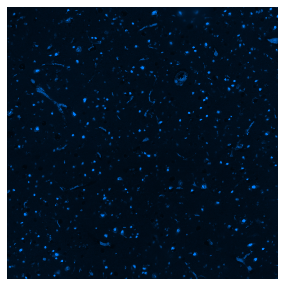

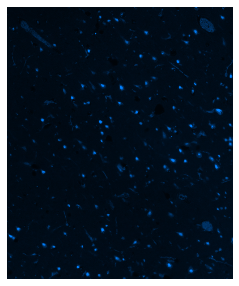

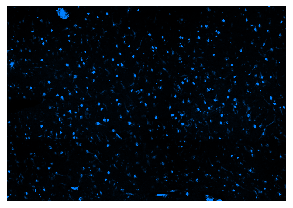

In [8]:
# images
path_img = Path('data/images')   # images go here
img_names = get_image_files(path_img)  # a list of posix filenames
# images are as expected?
load_image_test(img_names)

### Labels

There are 4 image files.
First image files:
0:	Name: data/labels_int/TrainingData_1_original_P.tif
	Shape: torch.Size([3, 3032, 3016])
	Array: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.003

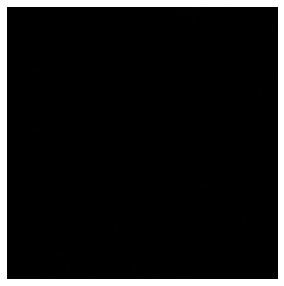

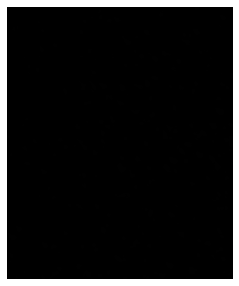

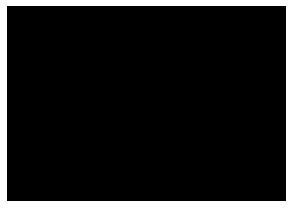

In [63]:
# load label images
path_lbl = Path('data/labels_int')   # labels go here
lbl_names = get_image_files(path_lbl)   # a list of posix filenames
load_image_test(lbl_names, label=True)  # custom function to visualize up to 3 label images and array data

In [60]:
# what are the unique values in the mask array
img = open_image(lbl_names[2])
np.unique(img.data[0])

array([0., 1.], dtype=float32)

In [32]:
'''
# converts image to grey scale and saves 
# only to be run once
img = pil_image.open('data/labels/TrainingData_3_original_P.tif').convert('L') # 'L' = 8-bit pixels, black and white
print(img.size)
print(img.mode)
img.save('data/labels_bw/TrainingData_3_original_P.tif')
'''

"\n# converts image to grey scale and saves \n# only to be run once\nimg = pil_image.open('data/labels/TrainingData_3_original_P.tif').convert('L') # 'L' = 8-bit pixels, black and white\nprint(img.size)\nprint(img.mode)\nimg.save('data/labels_bw/TrainingData_3_original_P.tif')\n"

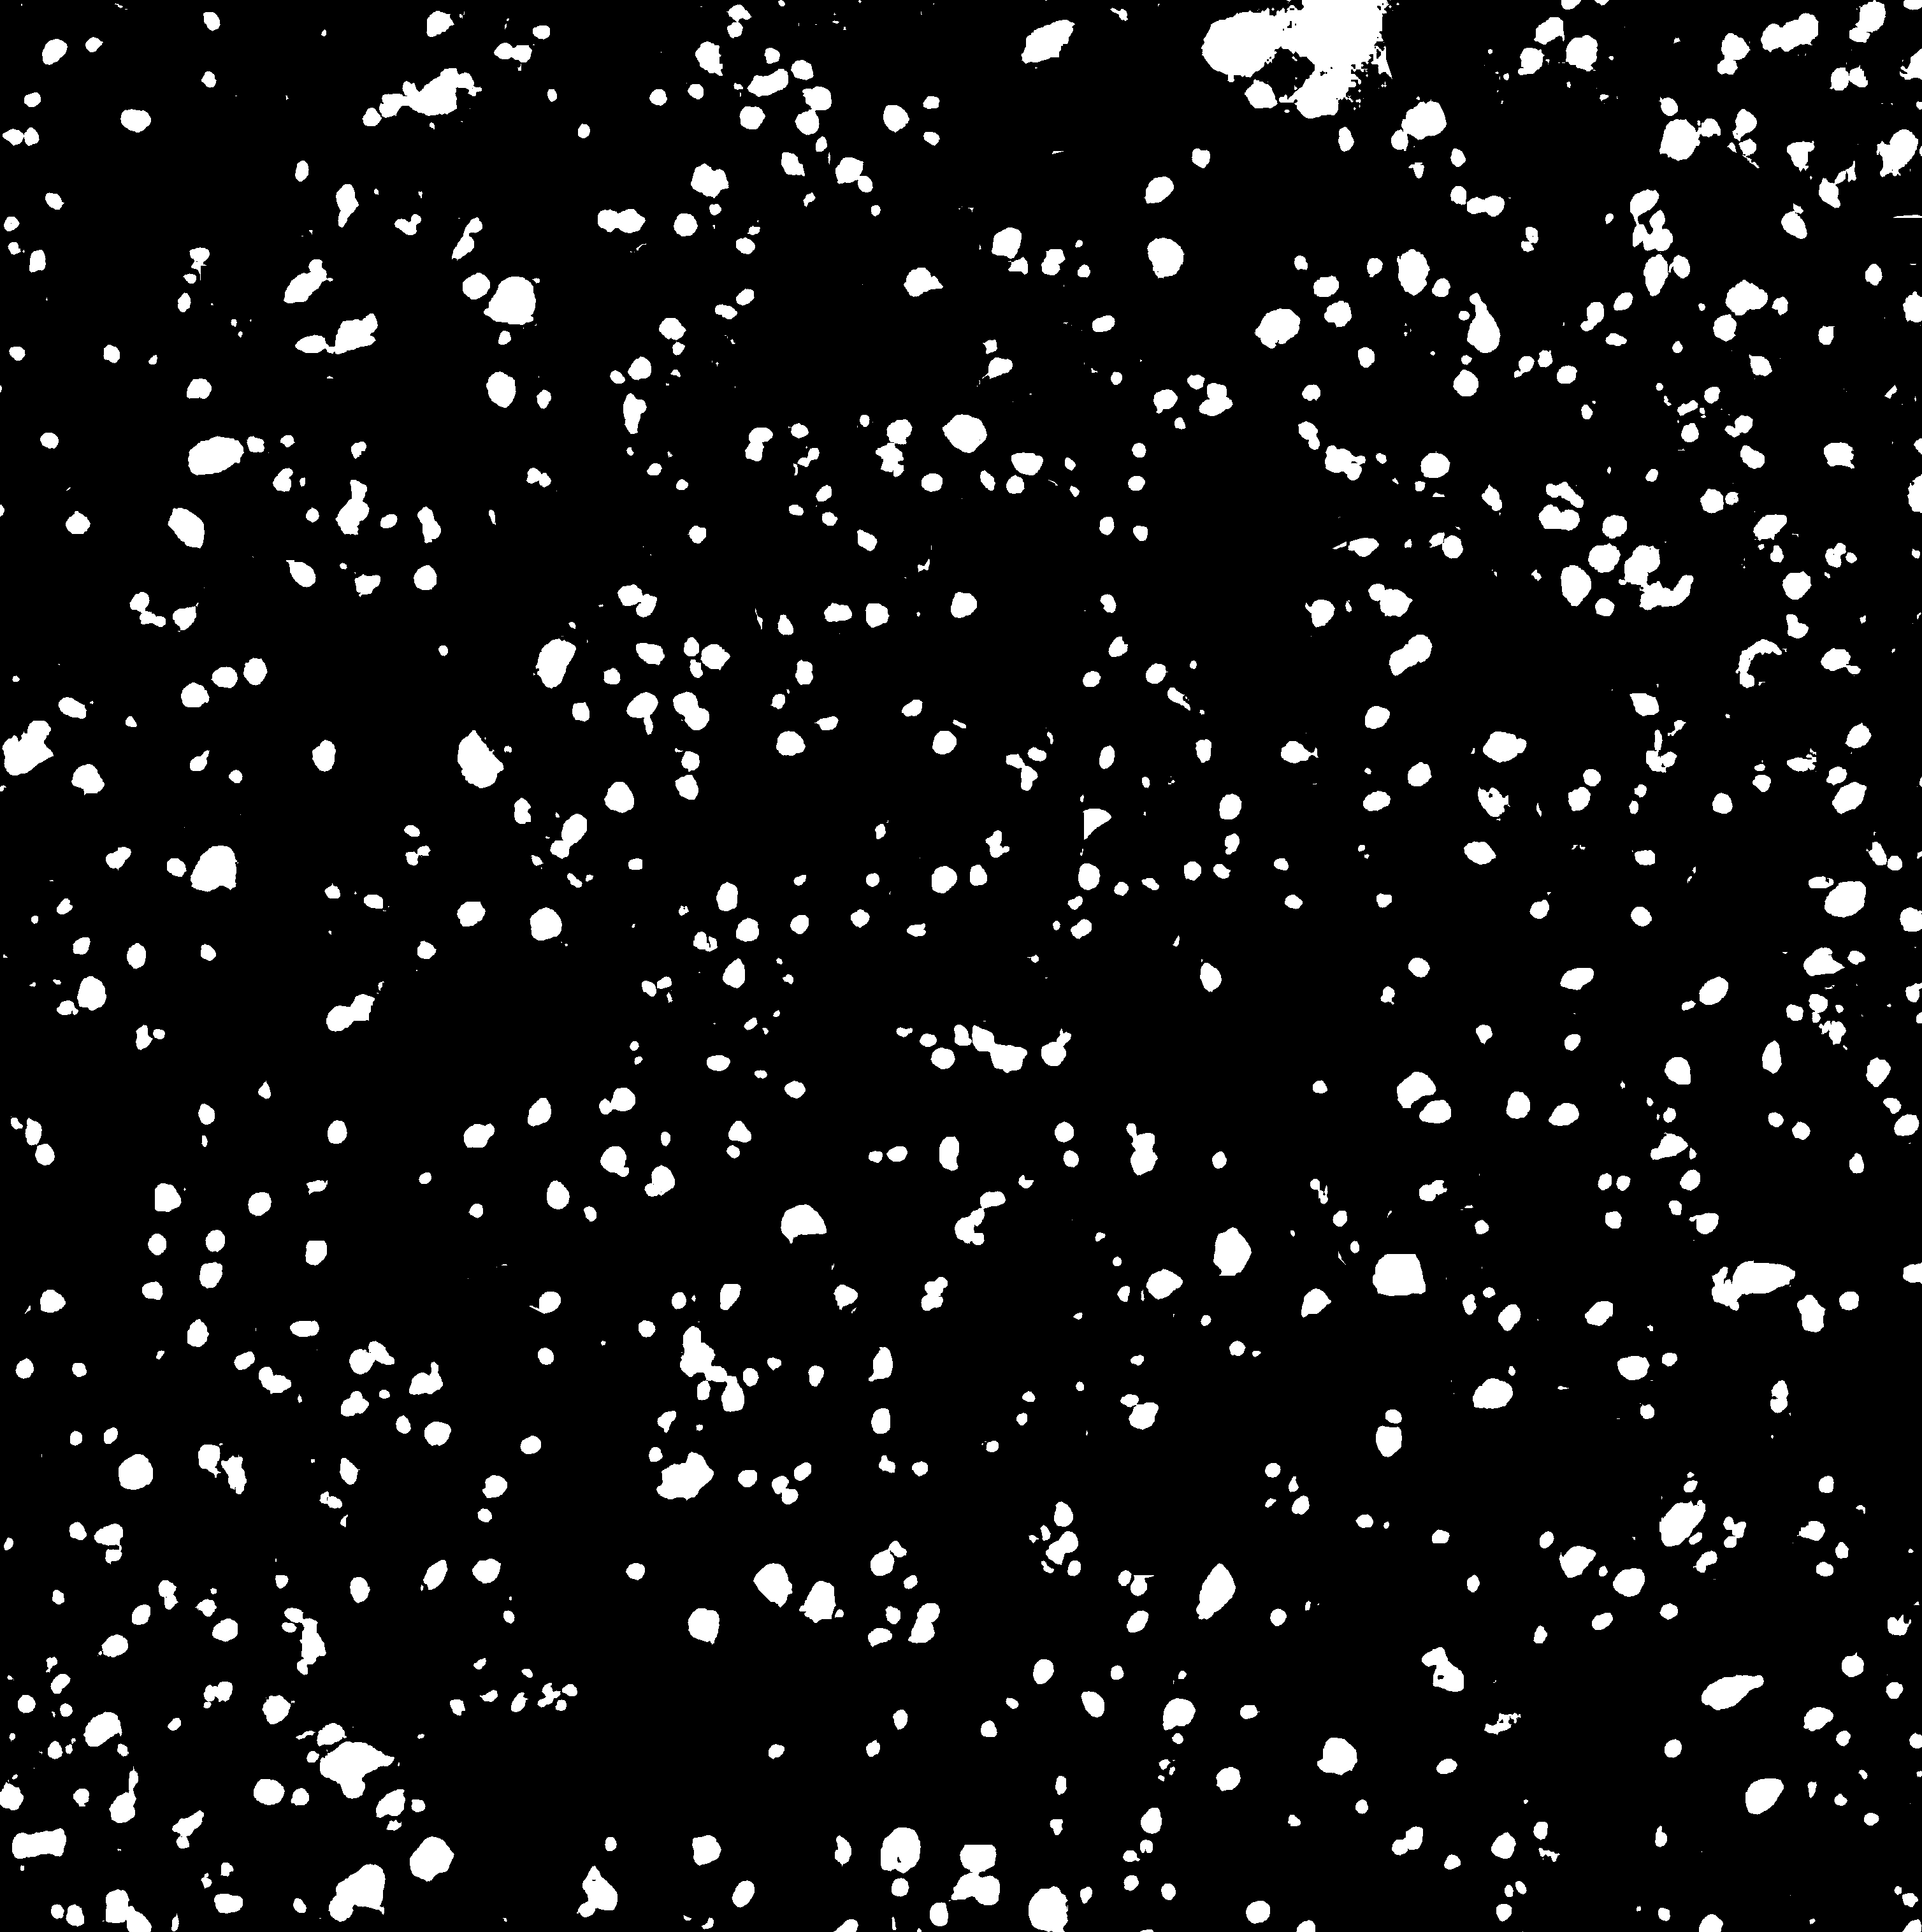

In [33]:
pil_image.open(lbl_names[0])

In [34]:
text_label_img = PIL.Image.open(lbl_names[0])

In [35]:
text_label_img= text_label_img.convert('L')

In [36]:
type(text_label_img)

PIL.Image.Image

In [37]:
'''
#folder_path = 
print(str(fnames))
display_img(path_img, fnames, 400, 400)
# all the images are very faint
'''

'\n#folder_path = \nprint(str(fnames))\ndisplay_img(path_img, fnames, 400, 400)\n# all the images are very faint\n'

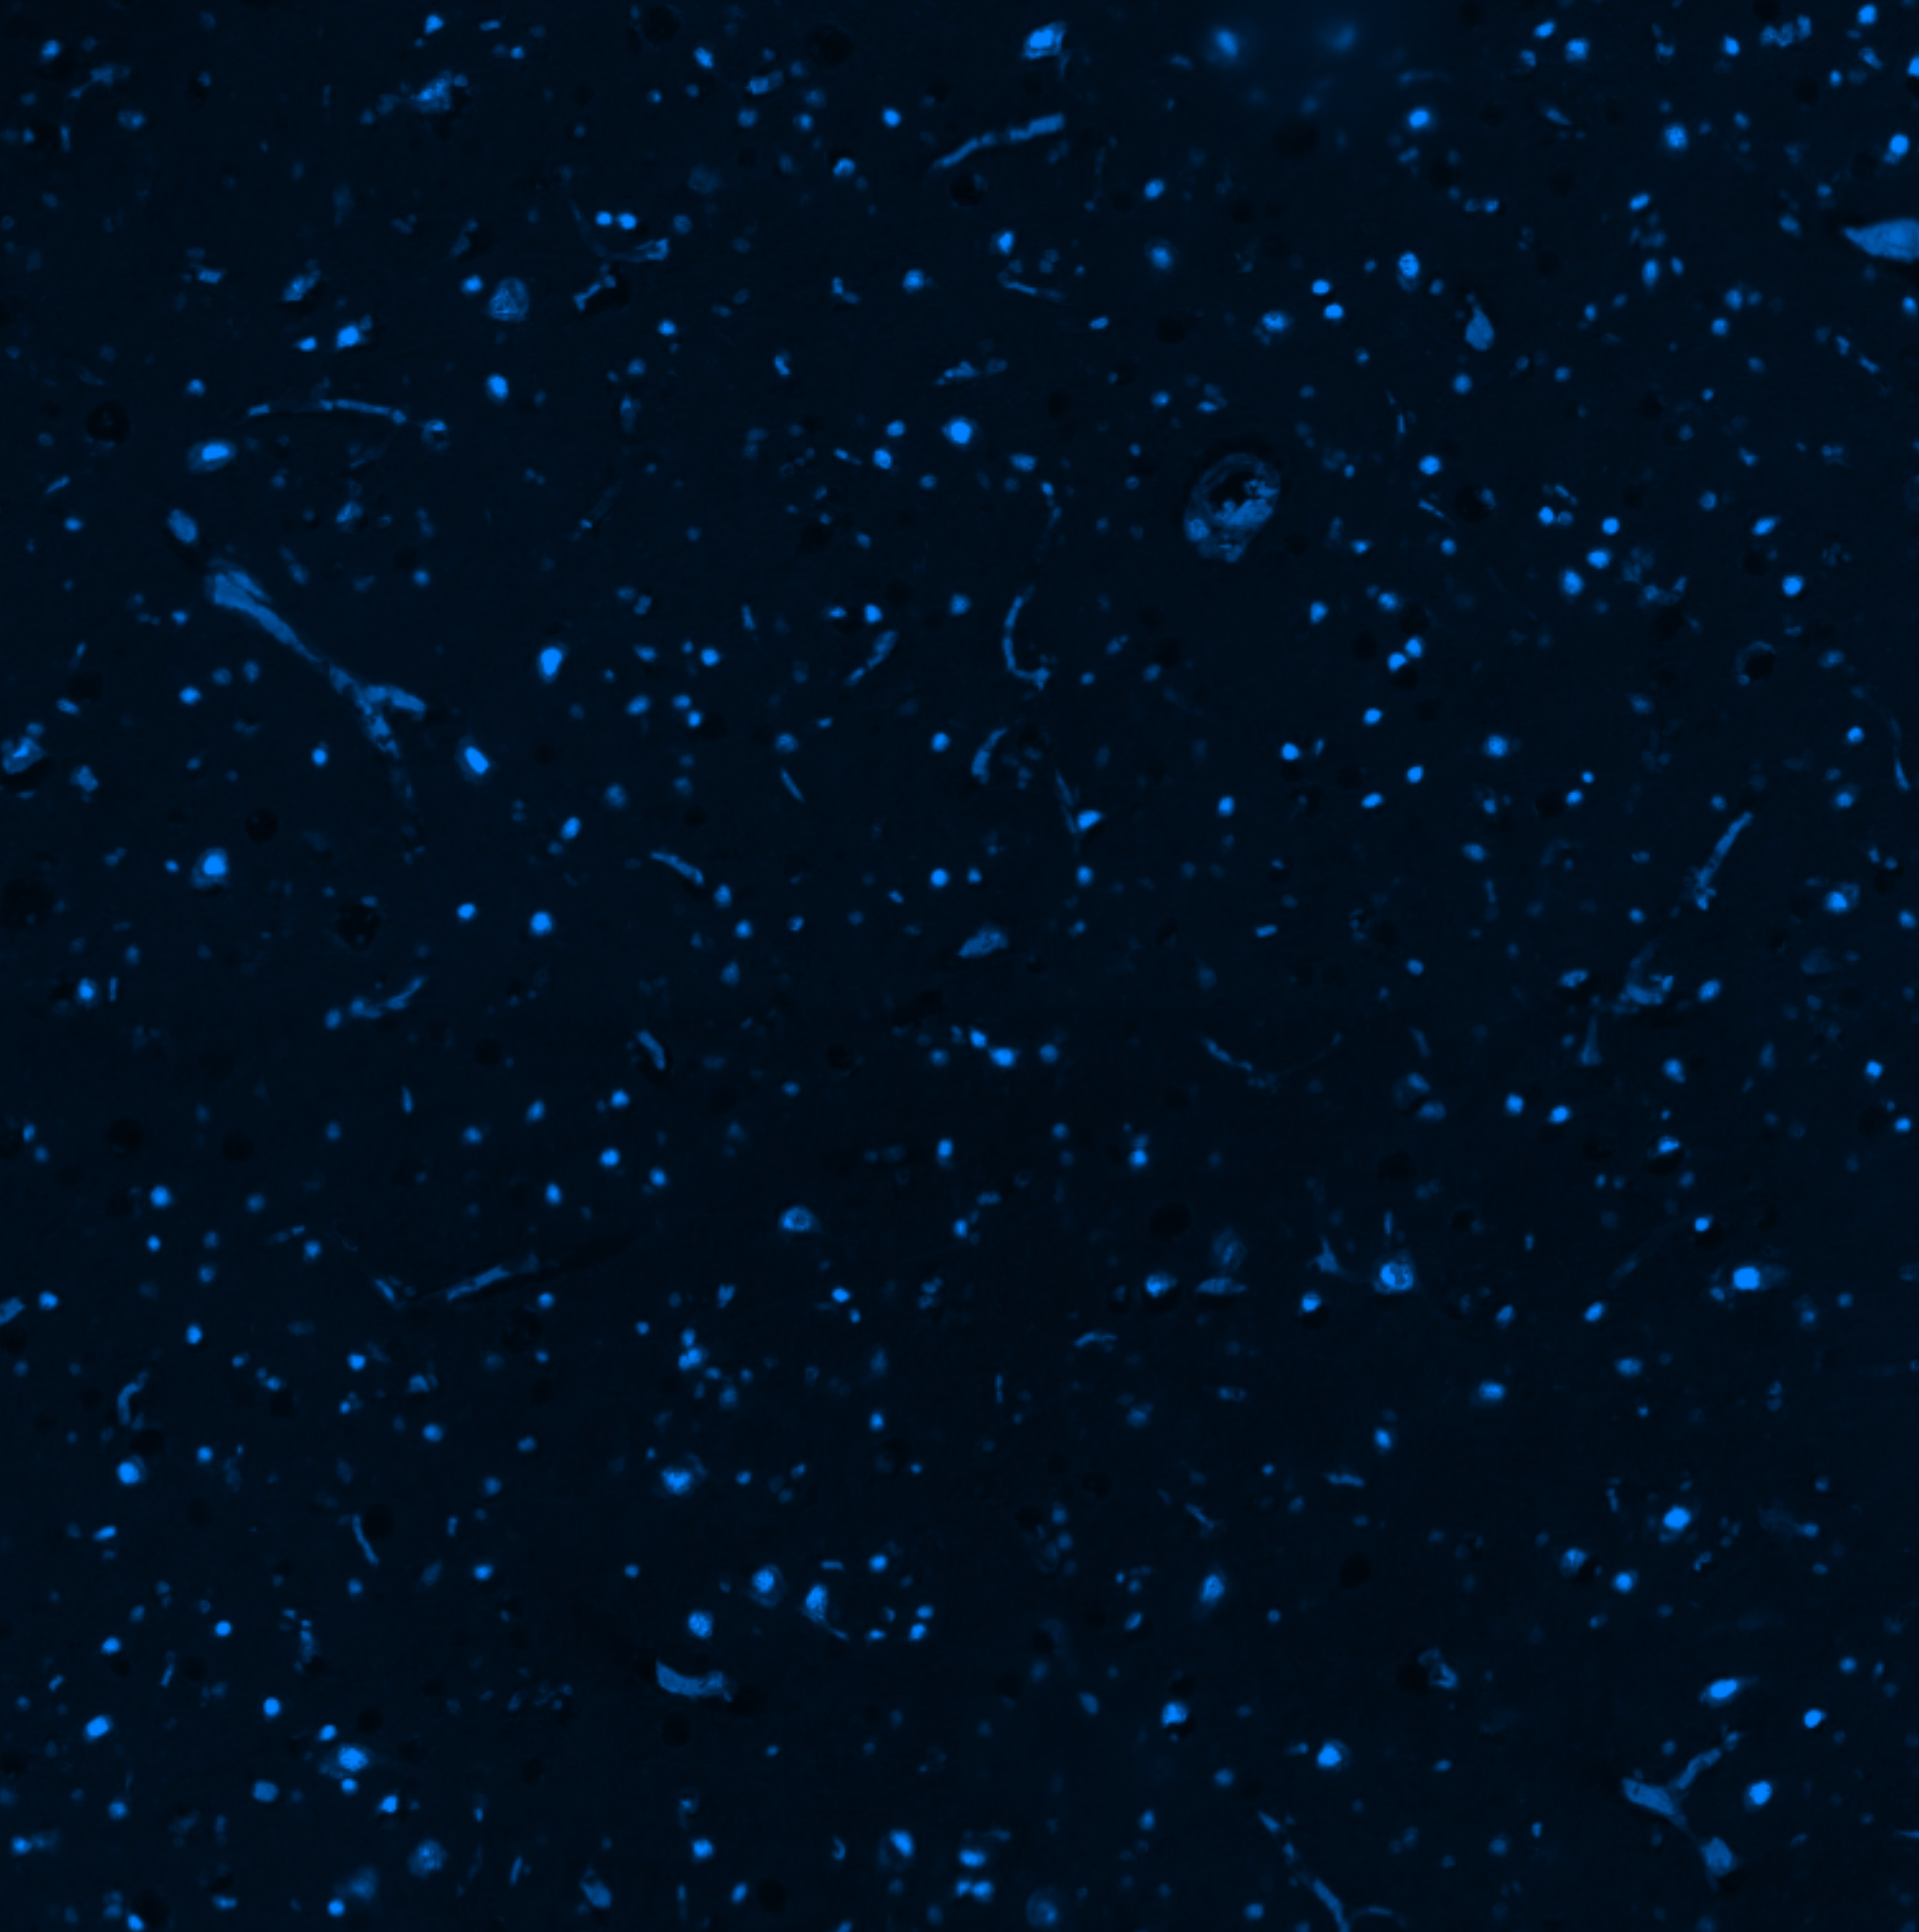

In [38]:
# display image inline using PIL library
PIL.Image.open(img_names[0])

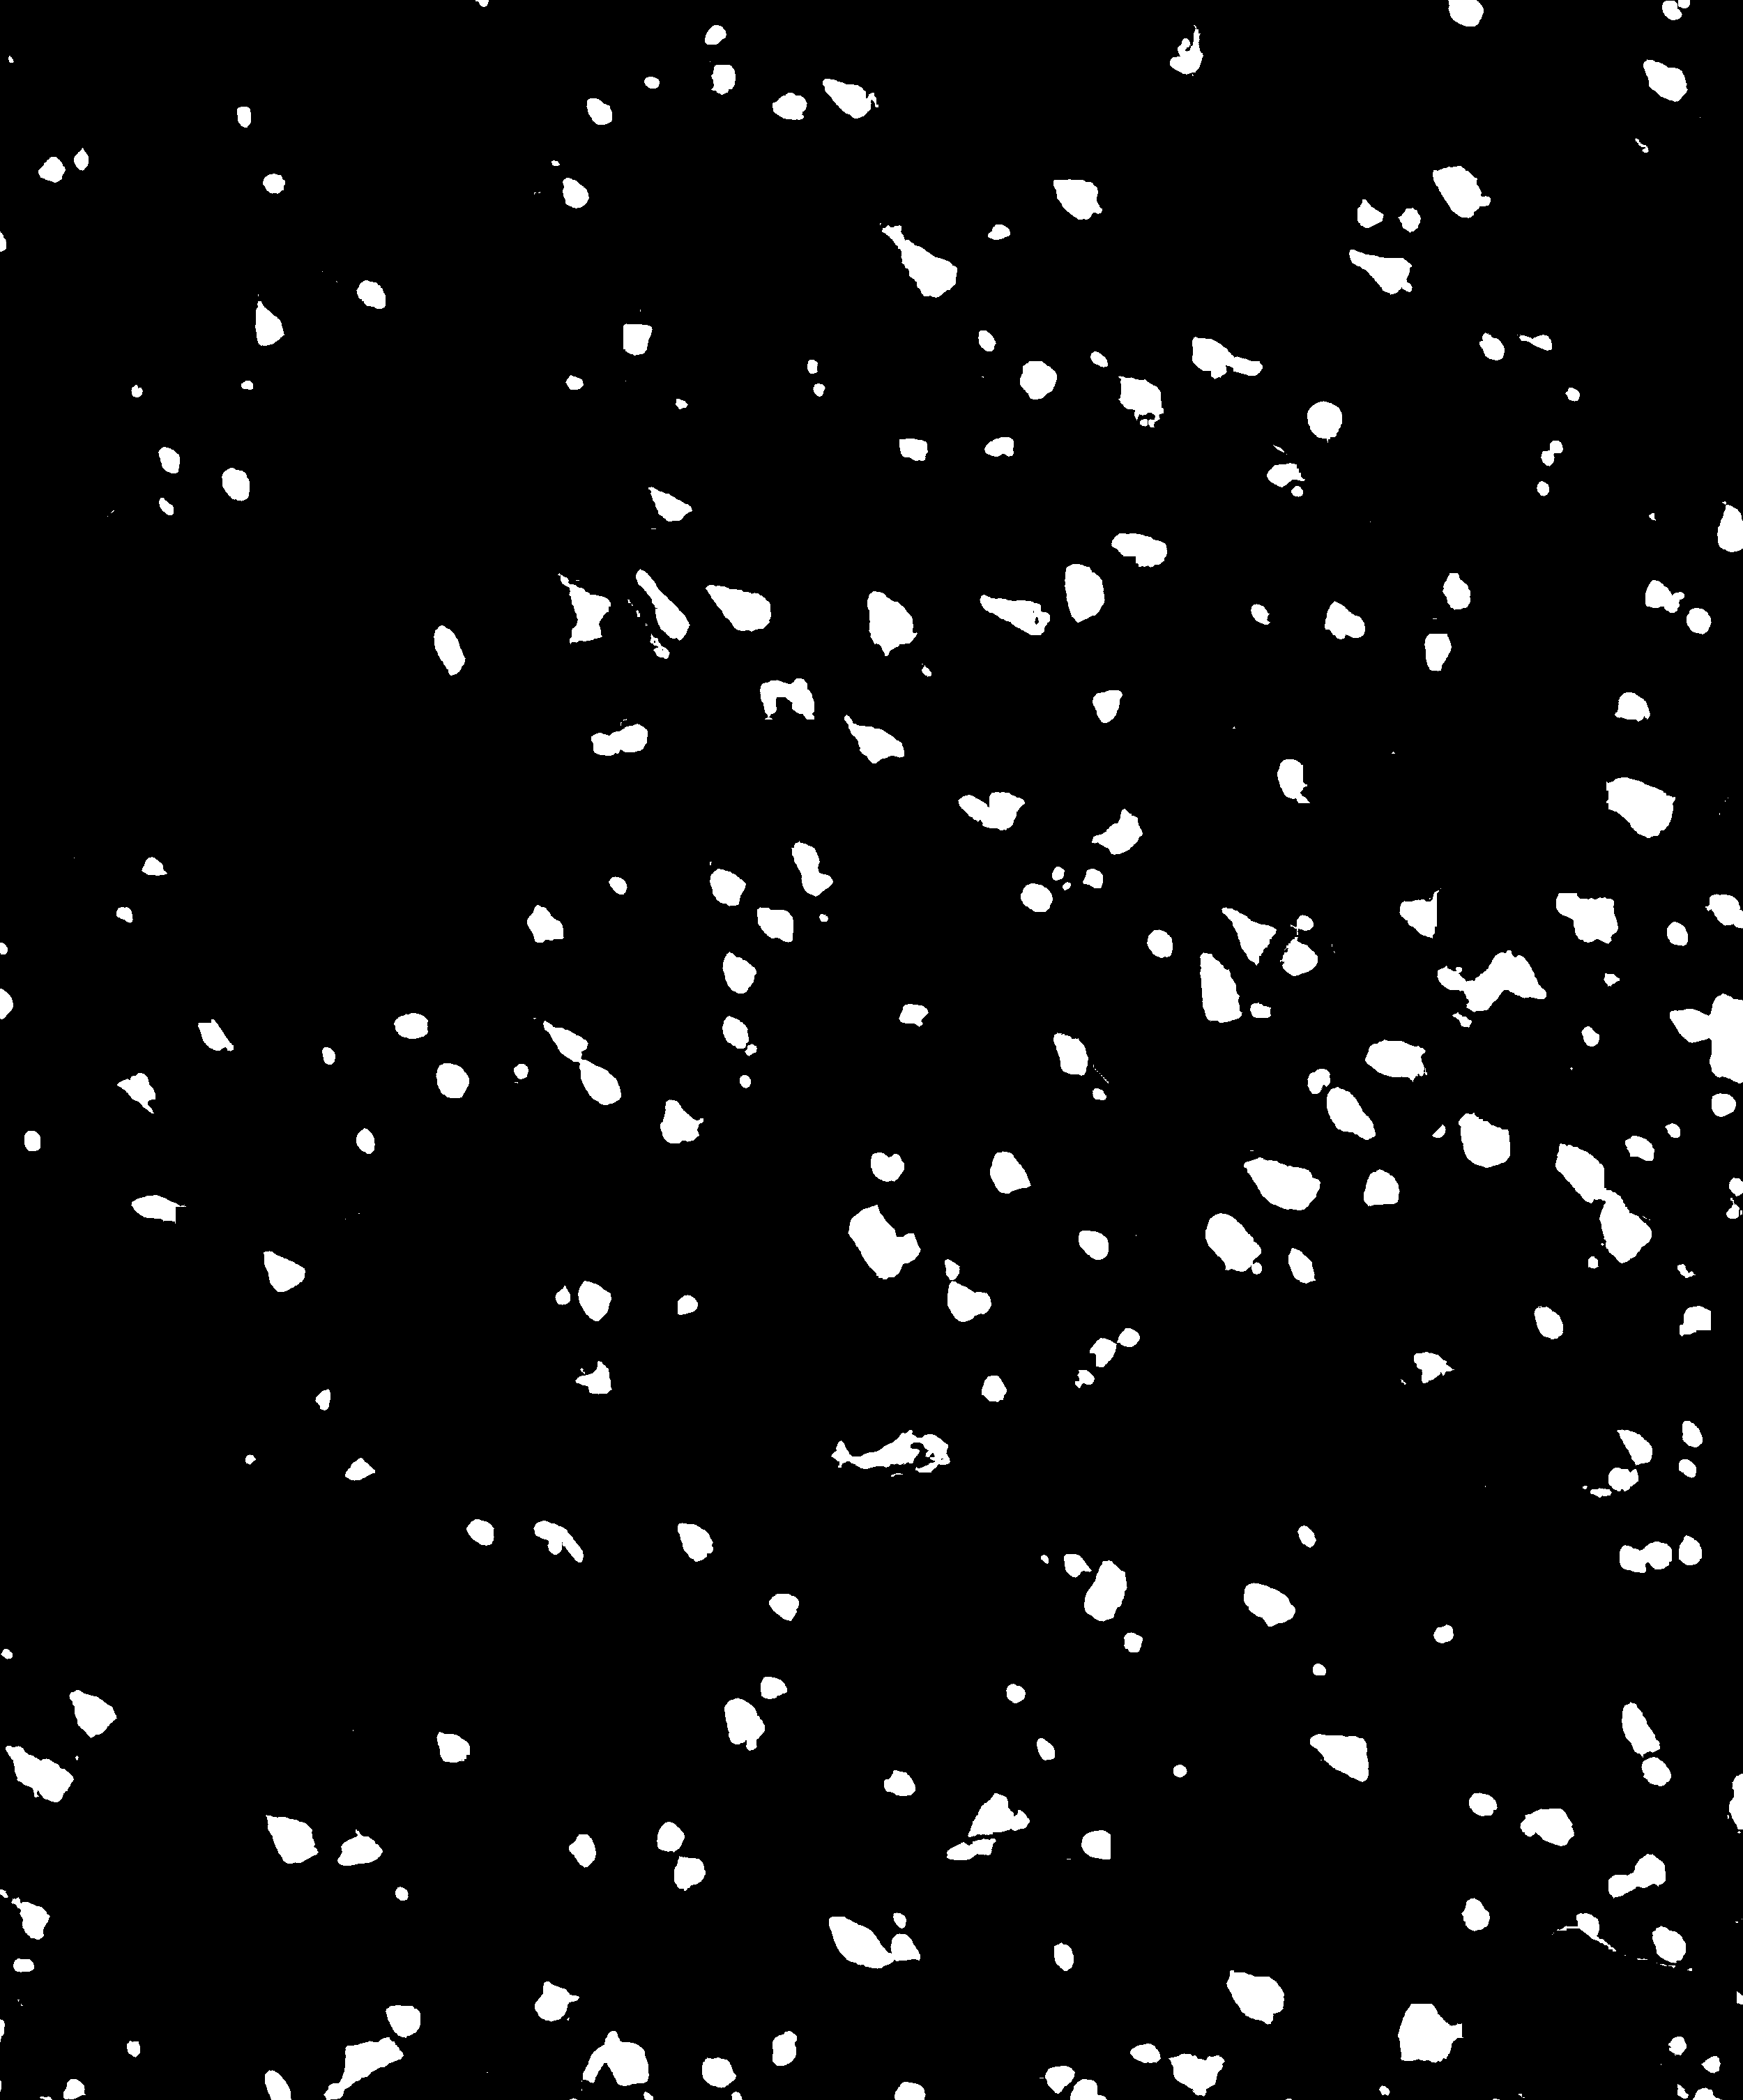

In [39]:
# display the lables inline
PIL.Image.open(lbl_names[1])

In [60]:
# display image in a separate window using PIL library
im = PIL.Image.open(img_names[0])
im.show()

In [61]:
img_names[0]

PosixPath('data/images/TrainingData_1_original.tif')

Size:[   1 2172 2424]
Color classes:[0 1]
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


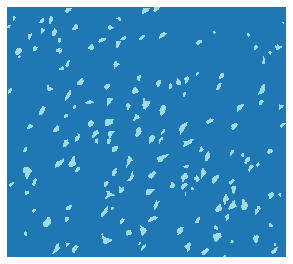

In [79]:
# Display an example mask using fastai function
mask = open_mask(get_y_fn(img_names[3]))   # open_mask is used for segmentation because integers, not floats
mask_size = np.array(mask.shape)
print("Size:{}".format(mask_size))
print("Color classes:{}".format(np.unique(mask.data)))
print(mask.data)
mask.show(figsize=(5, 5), alpha=1)
# note: default color is blue for display only.

#### 4.2 Define data object

[spliting training data into train/validation](http://google.com)

In [ ]:
'''
if CUDA error on JPG image load...then the tensor generated from the mask (ground truth map) 
may return values greater the number of classes. This code is intended to override the 
fastai 'open' method and processes the data as 0 or 1. Code needs to be optimized for 
current variables.

from fastai.vision.image import open_image, pil2tensor, ImageSegment
class CustomSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn, div=False).data
        x = pil2tensor(x, np.float32)
        return ImageSegment(x/x.max())
        
'''

In [80]:
# set transformations
tfms = get_transforms(flip_vert=True, max_warp=0.)   
# flip_vert=True: randomly flip images horizontally and vertically
# max_warp=0.:  warping allows for chanfe on perspective. To not use, set to 0. <- set to zero for satellites too

In [98]:
# load image data from folder
data = (SegmentationItemList.from_folder(path_img)   # load the data from a folder
        #.split_by_rand_pct()   # split data into training and validaiton sets by random percent
        .split_by_fname_file('../valid.txt')   # split data by folder if text file present
        #.split_none()     # if no validation data
        .label_from_func(get_y_fn, classes=codes, convert_mode='L')  # label data using 'get_y_fn' function
        .transform(tfms, tfm_y=True, size=64)  # flip image horizontally, we need to use tfm_y=True in the transform call because we need the same transforms to be applied to the target mask as were applied to the image
        .databunch(bs=2, path=Path('data'))  # create a databunch, 'bs' = batch size, 
        .normalize(imagenet_stats))  # normalize for resnet

In [99]:
data

ImageDataBunch;

Train: LabelList (3 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: data/images;

Valid: LabelList (1 items)
x: SegmentationItemList
Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64)
Path: data/images;

Test: None

In [100]:
# returns training imagae and label
data.train_ds[0]

(Image (3, 64, 64), ImageSegment (1, 64, 64))

In [101]:
data.valid_ds.classes

array(['background', 'neuron'], dtype='<U10')

overlay of masks on training images


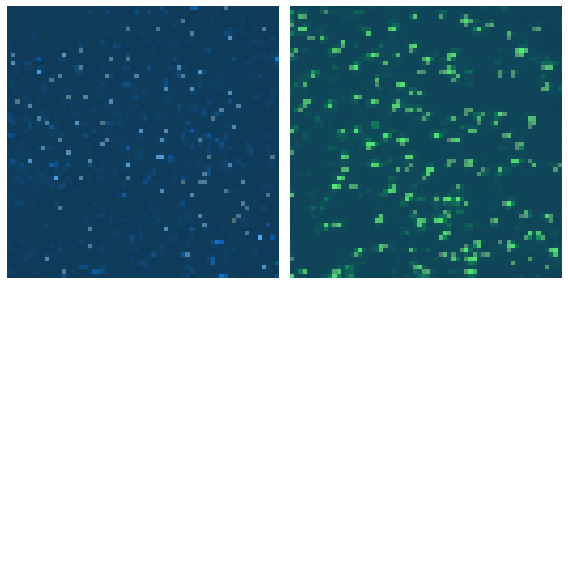

In [102]:
# do the masks align with the base image??
print("overlay of masks on training images")
data.show_batch(rows=2, figsize=(8,8))

## 5. Training
---

#### **5.1. Model**

Choosing the model architecture.  

The model architecture can be provided using fastai syntax. Example:
- `model = simple_cnn((3,16,16,2))`  builds a cnn model with a binary output with following layers: 

The fastai library includes several pretrained models from torchvision, namely:
- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet  

On top of the models offered by torchvision, fastai has implementations for the following models:

- Darknet architecture, which is the base of [Yolo v3](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
- Unet architecture based on a pretrained model. The original unet is described [here](https://arxiv.org/abs/1505.04597), the model implementation is detailed in [models.unet](https://docs.fast.ai/vision.models.unet.html#vision.models.unet)
- Wide resnets architectures, as introduced in [this article](https://arxiv.org/abs/1605.07146)

In [103]:
# simple CNN
#model = simple_cnn((3,16,16,2))  
model = models.resnet18  
#model = models.unet  # check this syntax.  

#### **5.2. Optimization Function**

Choose the optimization function. Options include:
- 'Adam'

Really Adam is the only one to use (for now). Fastai implementation uses decoupled weight regularization - don't know if this is true in pytorch. Adam combines elements of momentum with ....[ref](https://arxiv.org/abs/1711.05101)

In [104]:
opt_func = 'Adam'

#### **5.3. Loss Function**

Choose the loss function. Fastai defaults to None.

In [105]:
loss_func = None

#### **5.4. Learner**

Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.

`Learner (data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None, cb_fns_registered:bool=False)`

In [108]:
#learn = Learner(data, model)
#learn = cnn_learner(data, model)
#learn = unet_learner(data, model, opt_func=opt_func)  # not working
learn = unet_learner(data, model)
#learn = Learner.create_unet(data, model)   # not sure this works

#### 5.4.1. Metrics

In [109]:
# Metrics
# metrics always calculated on the validation set
learn.metrics=[accuracy]    # accuracy does not work on multilabel classification

#### 5.4.2. Callbacks

In [95]:
# Callbacks to modify training
#cb = OneCycleScheduler(learn, lr_max=0.01)   # this function not working

In [ ]:
# display the model architecture - summary has more info
#learn.model
#learn.summary

#### 5.4.3. Learning Rate Finder

The learning rate finder function is performed each time the model architecture is changed. Will perform a learning rate search step-wise through a range. 

Other strategies for hyperparameter optimization include:   
Uninformed
- grid search (worst, uninformed)
- random search  (better, uninformed)  

Bayesian optimization (sequential model-based optimization)
- gaussian processes
- random forest regression
- Tree of Parzen Estimators (TPE) (hyperopt) [ref](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)


Bayesian optimization, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, also called the surrogate or response surface, is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criteria (usually Expected Improvement) to the surrogate. The concept is to limit evals of the objective function by spending more time choosing the next values to try.


`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

wd:  weight decay. Use wd = 0.1 as a good starting point. "let’s not just add the sum of the squares of the parameters to the model but let’s multiply that by some number that we choose. And that number that we choose in fast is called wd"

In [111]:
# run learning rate finder
learn.lr_find(start_lr=1e-08, wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


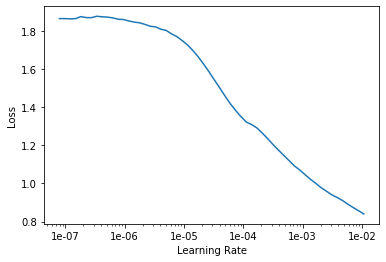

In [112]:
# plot the finder results
learn.recorder.plot()

In [113]:
lr = 5e-4

#### **5.5. Fit**

`fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)`

In [116]:
learn.data.single_ds.tfmargs['size'] = None 

In [ ]:
#n_epochs = 3
#learn.fit(epochs=n_epochs, callbacks=cb)
learn.fit_one_cycle(cyc_len=3, max_lr=slice(lr))    # normaly set 'cyc_len'=3
#learn.save('mini_train')   # this saves to the 'data' dir under a dir labeled 'models' (under .fastai if not local)

#### 6. Show Results
---

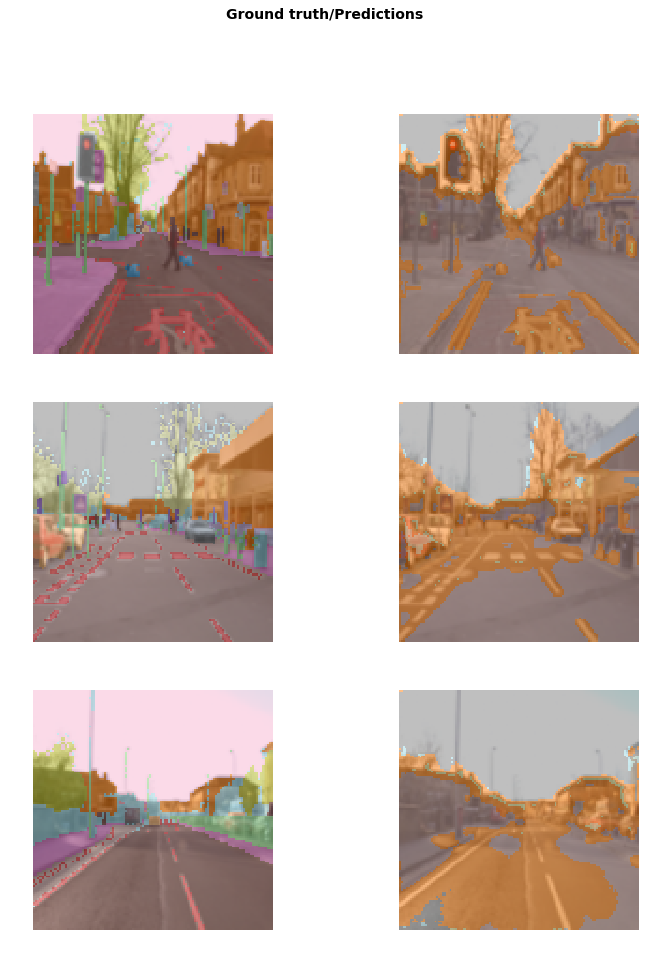

In [11]:
#learn.show_results()
learn.show_results(rows=3, figsize=(12,15))

## 7. Next Steps
---